In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from scipy.optimize import curve_fit

import gm2
import trfp
import plotting_functions as plt2
# import analysis_helper as helper
# import helper_function_candidates as helper_old
# import df_analysis_funcs as df_func
import helper_functions as helper

import field_map_config_run1 as map_config

from IPython.display import clear_output

pair_dict = map_config.pair_dict

def gaussian(x, A, s, x0):
    return A*np.exp(-(x-x0)**2/2/s**2)

def cor_to_cov(cor, sigma_a): return np.matmul(np.diag(sigma_a), np.matmul(cor, np.diag(sigma_a)))


Welcome to JupyROOT 6.22/02


In [2]:
# runs = map_config.runs

# columns = [['st'+str(st)+',dt'] +  ['st'+str(st)+',m'+str(m+1) for m in range(9)] for st in range(72)]
# columns = [item for sublist in columns for item in sublist]

# sync_offset_df = pd.DataFrame(columns=columns)

for run in runs:
    for pair in pair_dict[run]:

        file_name = 'hdf5/2020-09-30_run_'+run+'.h5'
        keys = pair_dict[run][pair]

        tr_dfs = {}

        tr_dfs[keys[0]] = pd.read_hdf(file_name, key=keys[0])
        tr_dfs[keys[1]] = pd.read_hdf(file_name, key=keys[1])

        tr_dfs = helper.interp_to_moment(tr_dfs, keys=keys)
        tr_dfs = helper.moment_to_corrected(tr_dfs, keys=keys)

        tr_hybrid_dfs = helper.bloch_style_moments(tr_dfs, keys=keys)

        sync_offsets, delta_time = helper.sync_offset_calc(tr_hybrid_dfs[keys[0]], tr_hybrid_dfs[keys[1]])
        row = {}

        for st in range(72):
            for m in range(9):
                row['st'+str(st)+',m'+str(m+1)] = sync_offsets[st,m]
            row['st'+str(st)+',dt'] = delta_time[st]
        
        sync_offset_df = sync_offset_df.append(pd.DataFrame(row, index=['run_'+run+pair[6]]))

        clear_output()
        print 'Done with run '+run+pair[6]
        
# sync_offset_df = sync_offset_df[columns]
# sync_offset_df = sync_offset_df.sort_index()

########################

# sync_offset_df.to_hdf('/data2/aetb/2021-01-12_hybrid_sync_offset_df.h5', key='sync_offset_df')

########################
########################
########################

sync_offset_df = pd.read_hdf('/data2/aetb/2021-01-12_hybrid_sync_offset_df.h5', key='sync_offset_df')

########################

sync_offset_df = sync_offset_df.iloc[0:-1]

# sync_offset_df.to_csv('sync_offsets.csv')

In [10]:
## compare my sync offsets to Bloch's

bloch_runs = ['run_1a1', 'run_1b1', 'run_1b2', 'run_1c1', 'run_1c2', 'run_1c3', 'run_1d3', 'run_1d4', 'run_1d5']
stms = ['st'+str(st)+',m1' for st in range(72)]

bloch_syncs = np.genfromtxt('sync_offsets_bloch_run1.txt', delimiter=',', skip_header=1)
bloch_syncs = -1*bloch_syncs[:,2:]
bloch_syncs_flat = bloch_syncs.flatten()

purc_syncs = sync_offset_df[stms].loc[bloch_runs].values/61.79
purc_syncs_flat = purc_syncs.flatten()

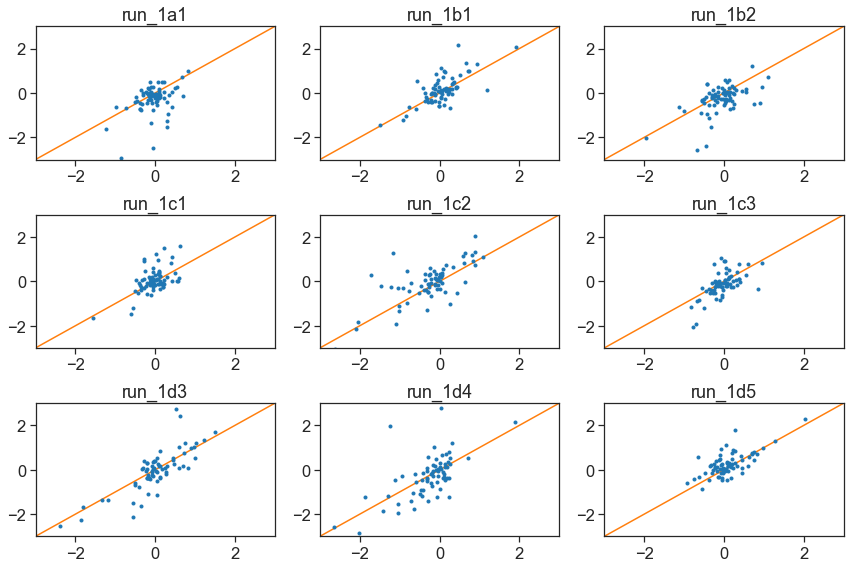

In [11]:
## compare my sync offsets to Bloch's

fig, axs = plt.subplots(3,3)

ii = 0
for row in axs:
    for ax in row:
        ax.plot(np.linspace(-3,3,3), np.linspace(-3,3,3), color='C1')
        ax.plot(bloch_syncs[ii,:], purc_syncs[ii,:], '.', color='C0')
        ax.set_title(bloch_runs[ii])
        ax.set_xlim([-3,3])
        ax.set_ylim([-3,3])
        ii += 1
        
fig.set_size_inches(12,8)
fig.tight_layout()

Text(0.5,0,'Bloch (ppm)')

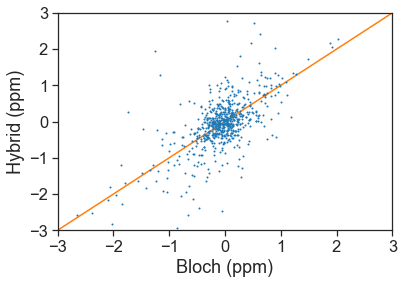

In [14]:
## compare my sync offsets to Bloch's

plt.plot(np.linspace(-3,3,3), np.linspace(-3,3,3), color='C1')
plt.plot(bloch_syncs_flat, purc_syncs_flat, '.', color='C0', ms=2)
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.ylabel('Hybrid (ppm)')
plt.xlabel('Bloch (ppm)')

In [ ]:
## compare my sync offsets to Bloch's

fig, axs = plt.subplots(24,3)

st = 0
for row in axs:
    for ax in row:
        ax.plot(np.linspace(-3,3,3), np.linspace(-3,3,3), color='C1')
        ax.plot(bloch_syncs[:,st], purc_syncs[:,st], '.', color='C0')
        ax.set_title('st'+str(st))
        ax.set_xlim([-3,3])
        ax.set_ylim([-3,3])
        st += 1

fig.set_facecolor('white')
fig.set_size_inches(12,64)
fig.tight_layout()

In [ ]:
plt.plot(np.sqrt(np.mean(purc_syncs**2.0, axis=0)), '.')
# plt.plot(np.std(purc_syncs, axis=0), '.')
plt.hlines(y=np.sqrt(np.mean(purc_syncs_flat**2, axis=0)), xmin=0, xmax=72, color='C1')

In [ ]:
plt.plot(np.sqrt(np.mean(purc_syncs**2.0, axis=1)), '.')
# plt.plot(np.std(purc_syncs, axis=0), '.')
plt.hlines(y=np.sqrt(np.mean(purc_syncs_flat**2)), xmin=0, xmax=8, color='C1')

In [ ]:
plt.plot(np.sqrt(np.mean(purc_syncs**2.0, axis=0)) - np.std(purc_syncs, axis=0), '.')

In [4]:
## use sync offsets by station to estimate correlation matrices for each moment

cor_matrices = np.empty((72,72,9))

for m in range(9):

    correlations = np.empty((11,72))

    for dataset in range(11):

        a = sync_offset_df[['st'+str(st)+',m'+str(m+1) for st in range(72)]].iloc[dataset].values

        correlation = np.empty(72)

        for ii in range(72):
            correlation[ii] = a.dot(np.roll(a, ii))
        correlations[dataset,:] = correlation/np.max(correlation)

    # plt.errorbar(np.arange(36), np.mean(correlations, axis=0)[0:36], np.std(correlations, axis=0)[0:36], fmt='.')
    # plt.hlines(0,0,36,color='r')
    # plt.plot(np.arange(36), np.power(mean_corr[1],np.arange(36)))

    mean_corr = np.mean(correlations, axis=0)

    cor_matrix = np.diag(np.ones(72), 0)

    for ii in range(1,20):
        cor_matrix += np.roll(np.diag(np.full(72, mean_corr[1]**ii)), ii, axis=0)
        cor_matrix += np.roll(np.diag(np.full(72, mean_corr[1]**ii)), -ii, axis=0)

    cor_matrices[:,:,m] = cor_matrix


In [5]:
## calculate standard rate for each moment using variance method
## assume a constant random walk rate across all stations and runs

rates = np.empty((792,9))
                 
for m in range(9):
    _ = np.array([])
    for st in range(72):
        _ = np.append(_, (sync_offset_df['st'+str(st)+',m'+str(m+1)]/sync_offset_df['st'+str(st)+',dt']**0.5).values)
    rates[:,m] = _

rates2 = rates**2

perc = 0.682

rate2 = np.empty(9)
for ii in range(9):
    rate2[ii] = np.quantile(rates2[:,ii], perc)
rate = np.sqrt(rate2)

print rate
print
print rate*60*1000/61.79

[0.06182849 0.01522728 0.013092   0.00866793 0.01508521 0.00431456
 0.00691106 0.00556848 0.00706706]

[60.03737901 14.78615925 12.71273328  8.41683099 14.64820258  4.18956783
  6.71085639  5.4071632   6.86233628]


In [6]:
## calculate ring wide rate

weights = np.full(72, 1./72.)

avg_rate2 = np.empty(9)

for m in range(9):
    cov_matrix = cor_to_cov(cor_matrices[:,:,m], np.full(72, rate[m]))
    avg_rate2[m] = np.dot(weights, np.dot(cov_matrix, weights))

print np.sqrt(avg_rate2)*60*1000/61.79
print
print avg_rate2  # this is the input to step 3

[10.53090193  1.91642629  1.38401718  0.95123419  3.26423746  0.52634664
  0.80640853  0.69557321  0.86907221]

[1.17615626e-04 3.89509569e-06 2.03150011e-06 9.59640992e-07
 1.13004927e-05 2.93817458e-07 6.89674412e-07 5.13120763e-07
 8.01024156e-07]


Text(0.5,0,'distance in stations')

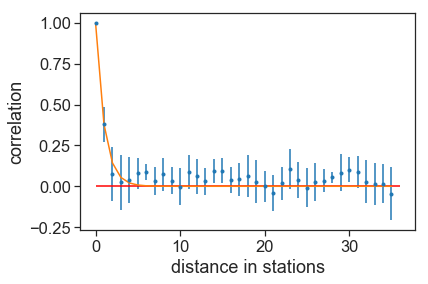

In [9]:
## rate correlations

correlations = np.empty((11,72))

for dataset in range(11):

    a = sync_offset_df[['st'+str(st)+',m1' for st in range(72)]].iloc[dataset].values

    correlation = np.empty(72)

    for ii in range(72):
        correlation[ii] = a.dot(np.roll(a, ii))
    correlations[dataset,:] = correlation/np.max(correlation)
    
mean_corr = np.mean(correlations, axis=0)
    
plt.errorbar(np.arange(36), mean_corr[0:36], np.std(correlations, axis=0)[0:36], fmt='.')
plt.hlines(0,0,36,color='r')
plt.plot(np.arange(36), np.power(mean_corr[1],np.arange(36)))


plt.ylabel('correlation')
plt.xlabel('distance in stations')

In [ ]:


mean_corr = np.mean(correlations, axis=0)

corr_matrix = np.diag(np.ones(72), 0)

for ii in range(1,10):
    corr_matrix += np.roll(np.diag(np.full(72, mean_corr[1]**ii)), ii, axis=0)
    corr_matrix += np.roll(np.diag(np.full(72, mean_corr[1]**ii)), -ii, axis=0)

# corr_matrix = (np.diag(np.ones(72), 0)
#                + np.roll(np.diag(np.full(72, mean_corr[1])), -1, axis=0)
#                + np.roll(np.diag(np.full(72, mean_corr[1])), 1, axis=0))

cov_matrix = cor_to_cov(corr_matrix, np.full(72, 60))  # 60 ppb/root hr
stupid_cov = np.diag(np.full(72, 3600))  # no correlation, 3600 ppb^2/hr

weights = np.full(72, 1./72.)

print np.dot(weights, np.dot(stupid_cov, weights))
print np.dot(weights, np.dot(stupid_cov, weights))**0.5
print
print np.dot(weights, np.dot(cov_matrix, weights))
print np.dot(weights, np.dot(cov_matrix, weights))**0.5


In [ ]:
values = np.empty((792,9))
                 
for m in range(9):
    _ = np.array([])
    for st in range(72):
        _ = np.append(_, (sync_offset_df['st'+str(st)+',m'+str(m+1)]).values)
    values[:,m] = _

# print np.sort(np.abs(values))

# m = 0
# counts, bins = np.histogram(rates[:,m], bins=50)

# # _ = plt.hist(rates[:,m], bins=50)
# _ = plt.hist(sync_offset_df[['st'+str(st)+',m1' for st in range(72)]].values.flatten(), bins=50)

m=0
counts, bins, _ = plt.hist(values[:,m]*1000/61.79, bins=100)
p0 = (100, 1000, 0)

bins = (bins[:-1] + bins[1:])/2

p, cov = curve_fit(gaussian,  bins,  counts, p0=p0)
print p

x = np.linspace(-2000, 2000, 500)
y = gaussian(x, *p)
plt.plot(x, y, '.')

print np.std(values[:,0]) * 1000 / 61.79

print (np.quantile(values[:,0], 0.5+0.341) - np.quantile(values[:,0], 0.5-0.341))/2 *1000 / 61.79
print (np.quantile(values[:,0], 0.5+0.475) - np.quantile(values[:,0], 0.5-0.475))/4 *1000 / 61.79
print (np.quantile(values[:,0], 0.5+0.495) - np.quantile(values[:,0], 0.5-0.495))/6 *1000 / 61.79

# plt.xlim([-2,2])

# print np.round(np.quantile(values[:,0]/61.79, 0.25), 3)
# print np.round(np.quantile(values[:,0]/61.79, 0.5), 3)
# print np.round(np.quantile(values[:,0]/61.79, 0.75), 3)

# ## find 1 "std" using quantiles
# print np.round((np.quantile(values[:,0]/61.79, 0.5 + 0.341) - np.quantile(values[:,0]/61.79, 0.5 - 0.341))/2, 3)
# print np.round((np.quantile(values[:,0]/61.79, 0.5 + 0.341) - np.quantile(values[:,0]/61.79, 0.5 - 0.341 - 0.136))/3, 3)
# print np.round((np.quantile(values[:,0]/61.79, 0.5 + 0.341 + 0.136) - np.quantile(values[:,0]/61.79, 0.5 - 0.341))/3, 3)
# print np.round((np.quantile(values[:,0]/61.79, 0.5 + 0.341 + 0.136) - np.quantile(values[:,0]/61.79, 0.5 - 0.341 - 0.136))/4, 3)

In [ ]:
counts, bins, _ = plt.hist(rates[:,m]*1000/61.79*60, bins=100)

In [ ]:
rates2 = rates**2

_ = plt.hist(rates2[:,0]*3600*(1000/61.79)**2, bins=500)
plt.xlim([0,0.1*3600*(1000/61.79)**2])

print np.quantile(rates2[:,0]*3600*(1000/61.79)**2, 0.682)
print np.quantile(rates2[:,0]*3600*(1000/61.79)**2, 0.682)**0.5
print
print np.quantile(rates2[:,0]*3600*(1000/61.79)**2, 0.95)
print np.quantile(rates2[:,0]*3600*(1000/61.79)**2, 0.95)**0.5
print
print np.quantile(rates2[:,0], 0.95)
print np.quantile(rates2[:,0], 0.95)**0.5

In [ ]:
## go by station, only have 11 pts

In [ ]:
## get the correlation function

In [ ]:
## bootstrapping
## resampling
## jackknife

#

values_ = values[:,m]

N = 10000
bootstrap = values_[np.random.randint(0,values_.size,N)]

_ = plt.hist(bootstrap, bins = 100)

In [ ]:
counts, bins, _ = plt.hist(rates[:,0]*60*1000/61.79, bins=100)
p0 = (100, 200, 0)

bins = (bins[:-1] + bins[1:])/2

p, cov = curve_fit(gaussian,  bins,  counts, p0=p0)

x = np.linspace(-250, 250, 200)
y = gaussian(x, *p)
plt.plot(x, y, '.')

print p[1]

print (np.quantile(rates[:,0], 0.5+0.341) - np.quantile(rates[:,0], 0.5-0.341))/2 * 60 *1000 / 61.79
print (np.quantile(rates[:,0], 0.5+0.475) - np.quantile(rates[:,0], 0.5-0.475))/4 * 60 *1000 / 61.79
print (np.quantile(rates[:,0], 0.5+0.495) - np.quantile(rates[:,0], 0.5-0.495))/6 * 60 *1000 / 61.79

In [ ]:
0.04778347491741227 * np.sqrt(72*3600)

In [ ]:
## this is the one I used

drift_rates = np.empty(9)

# p0 = (170, 0.01, 0)  # Hz sec
p0 = (170, .05, 0)

for m in range(9):
    counts, bins = np.histogram(rates[:,m], bins=50)
    bins = (bins[:-1]+bins[1:])/2
    p, cov = curve_fit(gaussian,  bins,  counts, p0=p0)

    drift_rates[m] = p[1]**2

print np.round(drift_rates, 6)  ## in Hz^2/sec
print np.round(drift_rates**0.5, 4)

# plt.semilogy(drift_rates, '.')

In [ ]:
46.4*np.sqrt(72)/12

In [ ]:
np.sort(values[:,0]/61.79)

In [ ]:
m = 0

counts, bins, _ = plt.hist(values[:,m]/61.79, bins=100)
plt.xlim([-2,2])

bins = (bins[:-1]+bins[1:])/2

p, cov = curve_fit(gaussian,  bins,  counts,  p0=(170, 0.1, 0))
print p
print
print cov

plt.plot(bins, p[0]*np.exp(-(bins - p[2])**2/p[1]**2))
print
print p[1]
print p[1]**2
print np.std(values[:,m]/61.79)

print np.std(values[:,m]/61.79)/np.sqrt(72)

In [ ]:
m = 0

counts, bins, _ = plt.hist(rates[:,m], bins=50)

bins = (bins[:-1]+bins[1:])/2

p, cov = curve_fit(gaussian,  bins,  counts,  p0=(170, 10, 0))
print p
print
print cov

plt.plot(bins, p[0]*np.exp(-(bins - p[2])**2/p[1]**2))

print p[1]
print p[1]**2
print np.std(rates[:,m])

print np.std(rates[:,m])/np.sqrt(72)

In [ ]:
p, cov = curve_fit(gaussian,  bins,  counts,  p0=(170, 0.1, 0))
print p
print
print cov

In [ ]:
plt.plot(bins, counts, '.')
plt.plot(bins, p[0]*np.exp(p[1]*bins))
plt.xlim([0,0.1])

In [ ]:
-1./p[1]

In [ ]:
np.sqrt(2)